# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Refit Model On All Available Data (excluding Big Mountain)](#5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain))
  * [5.7 Calculate Expected Big Mountain Ticket Price From The Model](#5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model)
  * [5.8 Big Mountain Resort In Market Context](#5.8_Big_Mountain_Resort_In_Market_Context)
    * [5.8.1 Ticket price](#5.8.1_Ticket_price)
    * [5.8.2 Vertical drop](#5.8.2_Vertical_drop)
    * [5.8.3 Snow making area](#5.8.3_Snow_making_area)
    * [5.8.4 Total number of chairs](#5.8.4_Total_number_of_chairs)
    * [5.8.5 Fast quads](#5.8.5_Fast_quads)
    * [5.8.6 Runs](#5.8.6_Runs)
    * [5.8.7 Longest run](#5.8.7_Longest_run)
    * [5.8.8 Trams](#5.8.8_Trams)
    * [5.8.9 Skiable terrain area](#5.8.9_Skiable_terrain_area)
  * [5.9 Modeling scenarios](#5.9_Modeling_scenarios)
    * [5.9.1 Scenario 1](#5.9.1_Scenario_1)
    * [5.9.2 Scenario 2](#5.9.2_Scenario_2)
    * [5.9.3 Scenario 3](#5.9.3_Scenario_3)
    * [5.9.4 Scenario 4](#5.9.4_Scenario_4)
  * [5.10 Summary](#5.10_Summary)
  * [5.11 Further work](#5.11_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now take our model for ski resort ticket price and leverage it to gain some insights into what price Big Mountain's facilities might actually support as well as explore the sensitivity of changes to various resort parameters. Note that this relies on the implicit assumption that all other resorts are largely setting prices based on how much people value certain facilities. Essentially this assumes prices are set by a free market.

We can now use our model to gain insight into what Big Mountain's ideal ticket price could/should be, and how that might change under various scenarios.

## 5.3 Imports<a id='5.3_Imports'></a>

In [8]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

## 5.4 Load Model<a id='5.4_Load_Model'></a>

In [9]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = '../models/ski_resort_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [10]:
ski_data = pd.read_csv('../data/ski_data_step3_features.csv')

In [11]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']

In [12]:
big_mountain.T

,125
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastEight,0
fastSixes,0
fastQuads,3


## 5.6 Refit Model On All Available Data (excluding Big Mountain)<a id='5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain)'></a>

This next step requires some careful thought. We want to refit the model using all available data. But should we include Big Mountain data? On the one hand, we are _not_ trying to estimate model performance on a previously unseen data sample, so theoretically including Big Mountain data should be fine. One might first think that including Big Mountain in the model training would, if anything, improve model performance in predicting Big Mountain's ticket price. But here's where our business context comes in. The motivation for this entire project is based on the sense that Big Mountain needs to adjust its pricing. One way to phrase this problem: we want to train a model to predict Big Mountain's ticket price based on data from _all the other_ resorts! We don't want Big Mountain's current price to bias this. We want to calculate a price based only on its competitors.

In [13]:
X = ski_data.loc[ski_data.Name != "Big Mountain Resort", model.X_columns]
y = ski_data.loc[ski_data.Name != "Big Mountain Resort", 'AdultWeekend']

In [14]:
len(X), len(y)

(278, 278)

In [15]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=54, n_jobs=None,
                                       oob_score=False, random_state=47,
                                       

In [16]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [10]:
cv_results['test_score']

array([-12.09690217,  -9.30247694, -11.41595784,  -8.10096706,
       -11.04942819])

In [17]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(10.318148232323232, 1.2002147437360884)

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

## 5.7 Calculate Expected Big Mountain Ticket Price From The Model<a id='5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model'></a>

In [18]:
X_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", model.X_columns]
y_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", 'AdultWeekend']

In [19]:
bm_pred = model.predict(X_bm).item()

In [20]:
y_bm = y_bm.values.item()

In [21]:
print(f'Big Mountain Resort modelled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}, this suggests there is room for an increase.')

Big Mountain Resort modelled price is $91.41, actual price is $81.00.
Even with the expected mean absolute error of $10.32, this suggests there is room for an increase.


This result should be looked at optimistically and doubtfully! The validity of our model lies in the assumption that other resorts accurately set their prices according to what the market (the ticket-buying public) supports. The fact that our resort seems to be charging that much less that what's predicted suggests our resort might be undercharging. 
But if ours is mispricing itself, are others? It's reasonable to expect that some resorts will be "overpriced" and some "underpriced." Or if resorts are pretty good at pricing strategies, it could be that our model is simply lacking some key data? Certainly we know nothing about operating costs, for example, and they would surely help.

## 5.8 Big Mountain Resort In Market Context<a id='5.8_Big_Mountain_Resort_In_Market_Context'></a>

Features that came up as important in the modeling (not just our final, random forest model) included:
* vertical_drop
* Snow Making_ac
* total_chairs
* fastQuads
* Runs
* LongestRun_mi
* trams
* SkiableTerrain_ac

A handy glossary of skiing terms can be found on the [ski.com](https://www.ski.com/ski-glossary) site. Some potentially relevant contextual information is that vertical drop, although nominally the height difference from the summit to the base, is generally taken from the highest [_lift-served_](http://verticalfeet.com/) point.

It's often useful to define custom functions for visualizing data in meaningful ways. The function below takes a feature name as an input and plots a histogram of the values of that feature. It then marks where Big Mountain sits in the distribution by marking Big Mountain's value with a vertical line using `matplotlib`'s [axvline](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axvline.html) function. It also performs a little cleaning up of missing values and adds descriptive labels and a title.

In [22]:
#Code task 1#
#Add code to the `plot_compare` function that displays a vertical, dashed line
#on the histogram to indicate Big Mountain's position in the distribution
#Hint: plt.axvline() plots a vertical line, its position for 'feature1'
#would be `big_mountain['feature1'].values, we'd like a red line, which can be
#specified with c='r', a dashed linestyle is produced by ls='--',
#and it's nice to give it a slightly reduced alpha value, such as 0.8.
#Don't forget to give it a useful label (e.g. 'Big Mountain') so it's listed
#in the legend.
def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Big Mountain's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    if state is None:
        ski_x = ski_data[feat_name]
    else:
        ski_x = ski_data.loc[ski_data.state == state, feat_name]
    ski_x = ski_x[np.isfinite(ski_x)]
    plt.hist(ski_x, bins=30)
    plt.axvline(x=big_mountain[feat_name].values, c='r', ls='--', alpha=0.8, label='Big Mountain')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for resorts in market share')
    plt.legend()

### 5.8.1 Ticket price<a id='5.8.1_Ticket_price'></a>

Look at where Big Mountain sits overall amongst all resorts for price and for just other resorts in Montana.

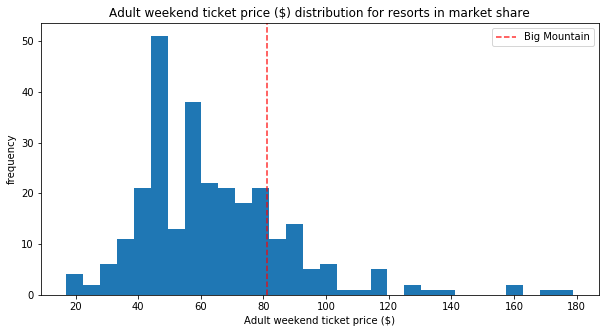

In [24]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($)')

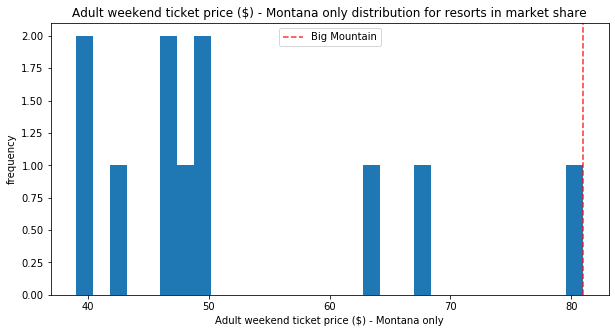

In [25]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($) - Montana only', state='Montana')

### 5.8.2 Vertical drop<a id='5.8.2_Vertical_drop'></a>

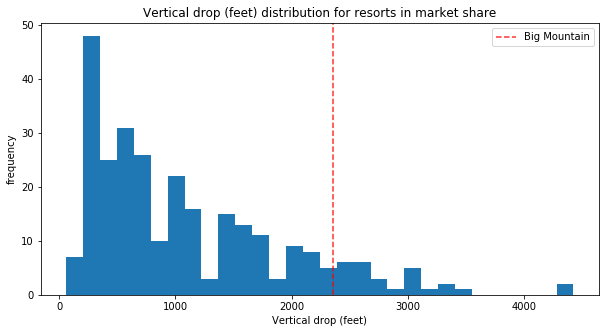

In [34]:
plot_compare('vertical_drop', 'Vertical drop (feet)')

Big Mountain is doing well for vertical drop, but there are still quite a few resorts with a greater drop.

### 5.8.3 Snow making area<a id='5.8.3_Snow_making_area'></a>

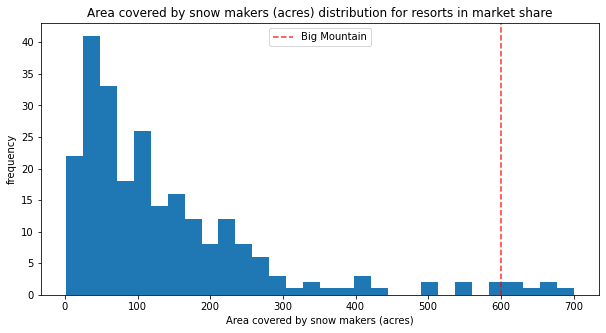

In [20]:
plot_compare('Snow Making_ac', 'Area covered by snow makers (acres)')

Big Mountain is very high up the league table of snow making area.

### 5.8.4 Total number of chairs<a id='5.8.4_Total_number_of_chairs'></a>

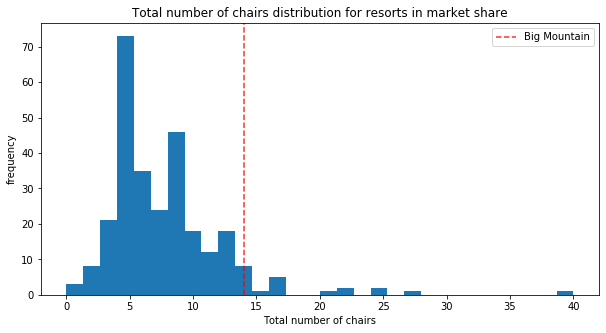

In [35]:
plot_compare('total_chairs', 'Total number of chairs')

Big Mountain has amongst the highest number of total chairs, resorts with more appear to be outliers.

### 5.8.5 Fast quads<a id='5.8.5_Fast_quads'></a>

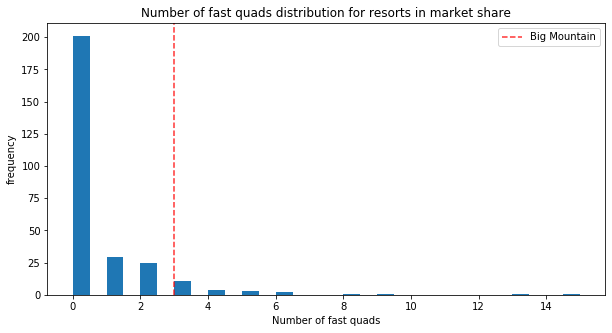

In [36]:
plot_compare('fastQuads', 'Number of fast quads')

Most resorts have no fast quads. Big Mountain has 3, which puts it high up that league table. There are some values  much higher, but they are rare.

### 5.8.6 Runs<a id='5.8.6_Runs'></a>

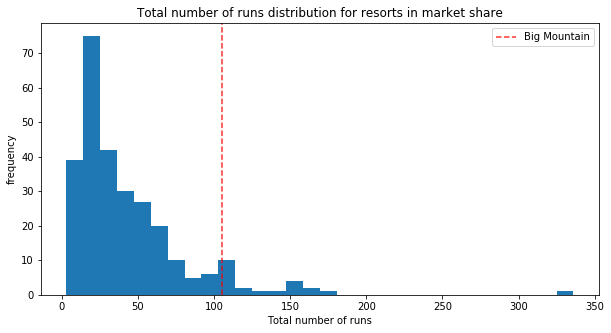

In [37]:
plot_compare('Runs', 'Total number of runs')

Big Mountain compares well for the number of runs. There are some resorts with more, but not many.

### 5.8.7 Longest run<a id='5.8.7_Longest_run'></a>

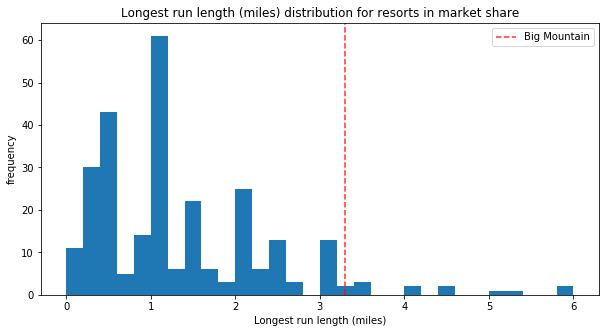

In [38]:
plot_compare('LongestRun_mi', 'Longest run length (miles)')

Big Mountain has one of the longest runs. Although it is just over half the length of the longest, the longer ones are rare.

### 5.8.8 Trams<a id='5.8.8_Trams'></a>

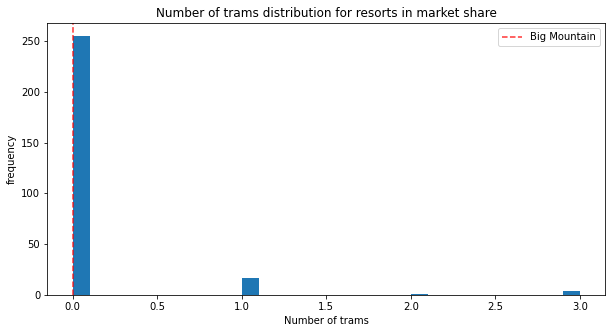

In [25]:
plot_compare('trams', 'Number of trams')

The vast majority of resorts, such as Big Mountain, have no trams.

### 5.8.9 Skiable terrain area<a id='5.8.9_Skiable_terrain_area'></a>

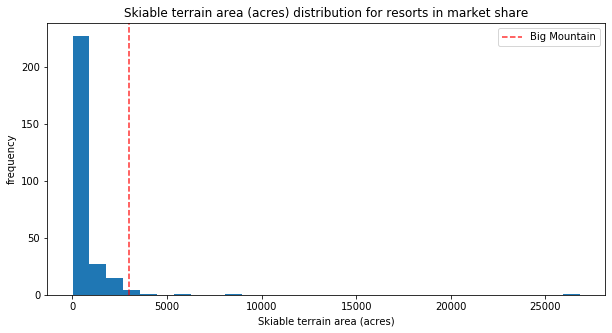

In [44]:
plot_compare('SkiableTerrain_ac', 'Skiable terrain area (acres)')

Big Mountain is amongst the resorts with the largest amount of skiable terrain.

**Student note:**  Adding the vertical lines representing Big Mountain makes it clear at a glance that the resort compares well with the others in the data set.

## 5.9 Modeling scenarios<a id='5.9_Modeling_scenarios'></a>

Big Mountain Resort has been reviewing potential scenarios for either cutting costs or increasing revenue (from ticket prices). Ticket price is not determined by any set of parameters; the resort is free to set whatever price it likes. However, the resort operates within a market where people pay more for certain facilities, and less for others. Being able to sense how facilities support a given ticket price is valuable business intelligence. This is where the utility of our model comes in.

The business has shortlisted some options:
1. Permanently closing down up to 10 of the least used runs. This doesn't impact any other resort statistics.
2. Increase the vertical drop by adding a run to a point 150 feet lower down but requiring the installation of an additional chair lift to bring skiers back up, without additional snow making coverage
3. Same as number 2, but adding 2 acres of snow making cover
4. Increase the longest run by 0.2 mile to boast 3.5 miles length, requiring an additional snow making coverage of 4 acres

The expected number of visitors over the season is 350,000 and, on average, visitors ski for five days. Assume the provided data includes the additional lift that Big Mountain recently installed.

In [39]:
expected_visitors = 350_000

In [40]:
all_feats = ['vertical_drop', 'Snow Making_ac', 'total_chairs', 'fastQuads', 
             'Runs', 'LongestRun_mi', 'trams', 'SkiableTerrain_ac']
big_mountain[all_feats]

,vertical_drop,Snow Making_ac,total_chairs,fastQuads,Runs,LongestRun_mi,trams,SkiableTerrain_ac
125,2353,600.0,14,3,105.0,3.3,0,3000.0


In [41]:
#Code task 2#
#In this function, copy the Big Mountain data into a new data frame
#(Note we use .copy()!)
#And then for each feature, and each of its deltas (changes from the original),
#create the modified scenario dataframe (bm2) and make a ticket price prediction
#for it. The difference between the scenario's prediction and the current
#prediction is then calculated and returned.
#Complete the code to increment each feature by the associated delta
def predict_increase(features, deltas):
    """Increase in modelled ticket price by applying delta to feature.
    
    Arguments:
    features - list, names of the features in the ski_data dataframe to change
    deltas - list, the amounts by which to increase the values of the features
    
    Outputs:
    Amount of increase in the predicted ticket price
    """
    
    bm2 = X_bm.copy()
    for f, d in zip(features, deltas):
        bm2[f] += d
    return model.predict(bm2).item() - model.predict(X_bm).item()

### 5.9.1 Scenario 1<a id='5.9.1_Scenario_1'></a>

Close up to 10 of the least used runs. The number of runs is the only parameter varying.

In [42]:
[i for i in range(-1, -11, -1)]

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]

In [43]:
runs_delta = [i for i in range(-1, -11, -1)]
price_deltas = [predict_increase(['Runs'], [delta]) for delta in runs_delta]

In [32]:
price_deltas

[0.0,
 -0.4057971014492807,
 -0.6666666666666714,
 -0.6666666666666714,
 -0.6666666666666714,
 -1.2608695652173907,
 -1.2608695652173907,
 -1.2608695652173907,
 -1.7101449275362341,
 -1.8115942028985472]

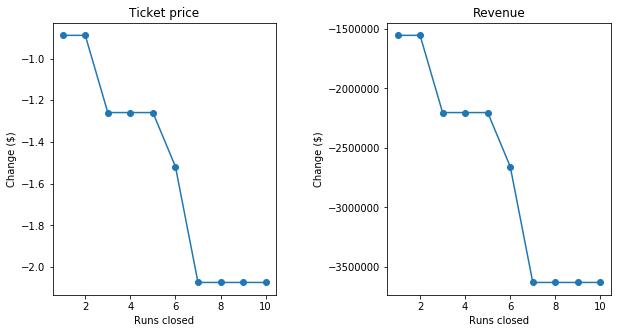

In [45]:
#Code task 3#
#Create two plots, side by side, for the predicted ticket price change (delta) for each
#condition (number of runs closed) in the scenario and the associated predicted revenue
#change on the assumption that each of the expected visitors buys 5 tickets
#There are two things to do here:
#1 - use a list comprehension to create a list of the number of runs closed from `runs_delta`
#2 - use a list comprehension to create a list of predicted revenue changes from `price_deltas`
runs_closed = [-1 * i for i in runs_delta] #1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(runs_closed, price_deltas, 'o-')
ax[0].set(xlabel='Runs closed', ylabel='Change ($)', title='Ticket price')
revenue_deltas = [5 * expected_visitors * delta for delta in price_deltas] #2
ax[1].plot(runs_closed, revenue_deltas, 'o-')
ax[1].set(xlabel='Runs closed', ylabel='Change ($)', title='Revenue');

The model says closing one run makes no difference. Closing 2 and 3 successively reduces support for ticket price and so revenue. If Big Mountain closes down 3 runs, it seems they may as well close down 4 or 5 as there's no further loss in ticket price. Increasing the closures down to 6 or more leads to a large drop. 

**Student note:** To me, it appears that we can close two runs without making any difference?

### 5.9.2 Scenario 2<a id='5.9.2_Scenario_2'></a>

In this scenario, Big Mountain is adding a run, increasing the vertical drop by 150 feet, and installing an additional chair lift.

In [46]:
#Code task 4#
#Call `predict_increase` with a list of the features 'Runs', 'vertical_drop', and 'total_chairs'
#and associated deltas of 1, 150, and 1
ticket2_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs'], [1, 150, 1])
revenue2_increase = 5 * expected_visitors * ticket2_increase

In [47]:
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')

This scenario increases support for ticket price by $1.24
Over the season, this could be expected to amount to $2171296


### 5.9.3 Scenario 3<a id='5.9.3_Scenario_3'></a>

In this scenario, you are repeating the previous one but adding 2 acres of snow making.

In [69]:
#Code task 5#
#Repeat scenario 2 conditions, but add an increase of 2 to `Snow Making_ac`
ticket3_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs', 'Snow Making_ac'], [1, 150, 1, 2])
revenue3_increase = 5 * expected_visitors * ticket3_increase

In [70]:
print(f'This scenario increases support for ticket price by ${ticket3_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue3_increase:.0f}')

This scenario increases support for ticket price by $1.24
Over the season, this could be expected to amount to $2171296


Such a small increase in the snow making area makes no difference!

### 5.9.4 Scenario 4<a id='5.9.4_Scenario_4'></a>

This scenario calls for increasing the longest run by .2 miles and guaranteeing its snow coverage by adding 4 acres of snow making capability.

In [85]:
#Code task 6#
#Predict the increase from adding 0.2 miles to `LongestRun_mi` and 4 to `Snow Making_ac`
predict_increase(['LongestRun_mi', 'Snow Making_ac'], [0.2, 4])

0.0

No difference whatsoever. Although the longest run feature was used in the linear model, the random forest model (the one we chose because of its better performance) only has longest run way down in the feature importance list. 

**Student note:** The following additional observations were made using the predict_increase function on this model:
1. Eliminating night skiing entirely would support a ticket price increase of 0.33 - I wonder how much operating expense could be saved with this step as well!  (All of these discussions are under the assumption that the model is correct and will be ACTUALLY predictive, of course.  These are some pretty big assumptions.)  

2. Adding just a single additional fastQuad would support a price increase of 23.61.  This suggests that there's a certain market segment who finds this feature highly desirable, and it's hard to imagine that such a ticket price increase wouldn't support the operating costs.  Adding a second fastQuad brings the predicted increase to 27.07; a third, to 27.81.  Adding a fourth produces no additional price increase, although higher values seem to approach 30.  It seems obvious that adding up to three fastQuads might be the most effective means to increase the ticket price that Big Mountain can justify.

3. On the other hand - and perhaps counterintuitively - adding a single tram REDUCES the projected ticket price by 26 cents.  Again, this is likely due to larger, mass-market resorts tending to depend on trams.  And this brings into question the very important concerns that remain unaddressed using the data resources available so far:  what is the customer base of Big Mountain like?  How will the number of tickets sold respond to increases in ticket price?  Obviously this must be considered by the business before actually increasing prices.  (PERSONAL NOTE:  running a tourist-oriented business, it was our experience that increasing prices and reducing the duration of our tours resulted in MORE bookings; the psychology of tourists is interesting, they are generally prepared to spend their money and I suspect that many of them presume that an activity is better if it costs more.)  Regardless, the model does not support adding a tram as a development that would support higher ticket prices.

4.  Interestingly, adding fastSixes produces less of a price increase than fastQuads:  0.97 for the first, with rapidly diminishing marginal returns.  Even more interestingly (in some strange way this confirms to me, intuitively, that this model has at least some relevance and utility) adding a fastSix IN COMBINATION with some fastQuads offers no advantage whatsoever over just adding the fastQuads.  Also, just now looking around the internet to see what 'fast quads' etc might be with respect to skiing (I should have done this very early on, really) I see that they're ski lifts.  

5.  Playing around with total_chairs, I found that increasing by just 1 resulted in a price increase of 0.74, increasing by 2 up to as many as 9 produced 7.79, and 10 or more produced 10.69.  However, in light of what I just learned about some of the other variables - are these chairs included in the 'fastQuads', etc?  The numbers for Big Mountain don't seem to if we make that assumption.  This is another instance of why it would have been helpful all along to have a really thorough and comprehensive data dictionary.  Also, if total_chairs is a sum of multiples of other variables, including it in the model introduces some pretty clear multicollinearity.



In [138]:
#Just screwing around with predict_increase
predict_increase(['NightSkiing_ac'], [-600])

0.3333333333333428

In [139]:
# Just screwing around some more with predict_increase
predict_increase(['fastQuads'], [1])

23.611111111111114

In [100]:
# Just screwing around some more with predict_increase
predict_increase(['trams'], [1])

-0.2592592592592524

In [118]:
# Just screwing around some more with predict_increase
predict_increase(['fastSixes'], [1])

0.9629629629629619

In [124]:
# Just screwing around some more with predict_increase
predict_increase(['fastQuads', 'fastSixes'], [2, 1])

27.074074074074076

In [137]:
# Just screwing around some more with predict_increase
for i in range(20):
    print("chairs added:", i, "predicted price increase:", predict_increase(['total_chairs'], [i]))

chairs added: 0 predicted price increase: 0.0
chairs added: 1 predicted price increase: 0.0
chairs added: 2 predicted price increase: 1.7407407407407476
chairs added: 3 predicted price increase: 7.888888888888886
chairs added: 4 predicted price increase: 7.888888888888886
chairs added: 5 predicted price increase: 7.888888888888886
chairs added: 6 predicted price increase: 7.888888888888886
chairs added: 7 predicted price increase: 7.888888888888886
chairs added: 8 predicted price increase: 7.888888888888886
chairs added: 9 predicted price increase: 7.888888888888886
chairs added: 10 predicted price increase: 10.68518518518519
chairs added: 11 predicted price increase: 10.68518518518519
chairs added: 12 predicted price increase: 10.68518518518519
chairs added: 13 predicted price increase: 10.68518518518519
chairs added: 14 predicted price increase: 10.68518518518519
chairs added: 15 predicted price increase: 10.68518518518519
chairs added: 16 predicted price increase: 10.68518518518519


## 5.10 Summary<a id='5.10_Summary'></a>

**Q: 1** Write a summary of the results of modeling these scenarios. Start by starting the current position; how much does Big Mountain currently charge? What does your modelling suggest for a ticket price that could be supported in the marketplace by Big Mountain's facilities? How would you approach suggesting such a change to the business leadership? Discuss the additional operating cost of the new chair lift per ticket (on the basis of each visitor on average buying 5 day tickets) in the context of raising prices to cover this. For future improvements, state which, if any, of the modeled scenarios you'd recommend for further consideration. Suggest how the business might test, and progress, with any run closures.

**A: 1** Big Mountain currently charges 81 dollars per ticket. Examining Big Mountain's features, it was immediately clear that this current ticket price is low, compared to other resorts nationally    (**FIND PERCENTILE**) with the same characteristics, and the random forest model on which we settled, when given all of Big Mountain's predictors, produced a predicted ticket price of 91.41, with a mean absolute error of 10.32.  This suggests that Big Mountain is already undercharging for its tickets. 

With 350,000 visitors per year, each staying an average of 5 days, the 81 dollar ticket price produces a gross annual revenue of 141,750,000 dollars per year.  We don't know the operating cost of this business; we do know, however, that the addition of a single lift has entailed an additional operating cost of 1.5 million.  This seems large to me, but then I know next to nothing about this hardware.  However, as the resort stands now, our model suggests that ticket prices could be increased by around ten dollars, which would produce additional annual revenue of 17.5 million - more than ten times the increased operating cost that must be covered.  

Big Mountain outlined four proposed changes to their facilities that were examined with respect to projected ticket price using this model.  The first was to close down some of the runs.  Presumably, this was proposed for the purpose of reducing operating costs, and it was found that under our model Big Mountain could close down two runs with no adverse result to predicted ticket price.  The second and third options involved increasing vertical drop by 150 feet, with and without adding two acres of snow making coverage.  The model predicts a price increase of 1.24, whether or not we included the extra snow making.  Finally, we considered increasing the longest run by 0.2 miles, and adding 4 acres of snow making; this produced no difference at all.

In addition to these proposed changes, I experimented with the model a little, and found some other changes that might support higher ticket prices.  Surprisingly, eliminating night skiing entirely would support a ticket price increase of 33 cents.  I find this questionable in practice; but possibly, removing night skiing wouldn't diminish the price that Big Mountain can charge, and might result in very substantial operating cost savings.  I am more confident in the prediction that adding a single fastQuad would increase the predicted ticket price by 23.61, and adding two would increase it by 27.07.  Of course, this would entail substantial startup and maintenance costs, but it's hard to imagine the increase in price wouldn't be more than adequate.  It also turned out that adding a tram would actually decrease the predicted ticket price. 

In conclusion - and more data is needed to determine with any reliability whether these changes would be profitable - what I would suggest to Big Mountain is to immediately increase their ticket price to $90, as the model suggests they're undercharging for what they offer.  I would also suggest closing down two of the least popular runs, increasing the vertical drop by 150 feet as discussed, eliminating night skiing, and adding two fastQuads.  These changes, once implemented, would support increasing the ticket price by another 28.64; rounding this down to 28 gives us a ticket price of 118 dollars.  Assuming that ticket sales remain constant, this represents an additional 64.75 million in annual revenue. 

## 5.11 Further work<a id='5.11_Further_work'></a>

**Q: 2** What next? Highlight any deficiencies in the data that hampered or limited this work. The only price data in our dataset were ticket prices. You were provided with information about the additional operating cost of the new chair lift, but what other cost information would be useful? Big Mountain was already fairly high on some of the league charts of facilities offered, but why was its modeled price so much higher than its current price? Would this mismatch come as a surprise to the business executives? How would you find out? Assuming the business leaders felt this model was useful, how would the business make use of it? Would you expect them to come to you every time they wanted to test a new combination of parameters in a scenario? We hope you would have better things to do, so how might this model be made available for business analysts to use and explore?

**A: 2** In the first place, I encountered some runtime warnings in the development of the model in the preceding notebook that I still haven't figured out.  Unless I can determine at least what caused them, and satisfy myself that this hasn't made the model parameters unreliable, I hesitate to certify any of the conclusions drawn from the model.  I can say the behavior of the model made intuitive sense on many points, which makes it seem more credible to me; regardless, I need to know why so many runtime warnings popped up.

This aside, the major deficiency that's hampered this work has been the lack of any kind of data dictionary for the initial data set.  It would have been preferable to know precisely to what all of those variables refer.  In addition, a more complete study would require a lot more sales and marketing data from Big Mountain, data that I'm certain already exist and are being used by stakeholders.  I don't even have a list of names to email.  It was quite a revelation to learn that they receive 350,000 visitors per season, with an average stay of 5 days - I'd like to know how that average breaks down, and also how the number of visitors in past seasons has changed over time.  Especially with respect to previous changes in the ticket price.  

It would also be useful to know about the installation and operating cost for the various resources enumerated in the data set.  How much does it cost them to install a new fastQuad, and how much does it cost to operate?  Etc.  We have no information on this whatsoever, and obviously this relates crucially to an analysis of the decisions that might be made.

Another deficiency is perhaps more subtle:  all of the data we have tell us how many the resorts have of various things:  night skiing acreage, runs, lifts, etc.  They tell us nothing about the relative quality of these factors.  I can't imagine that someone who engages in skiing regularly would fail to discern differences among these at various resorts.  This might be difficult to assess, but I would imagine that Big Mountain Resort maintains records on customer satisfaction, and perhaps some useful data could be gleaned from them.

In addressing this with executives, I might begin by presenting them the histograms representing resort resources featuring Big Mountain represented by a vertical line, and then conclude with the histogram for ticket price.  This should make the point quite powerfully:  it's obvious at a glance how favorable Big Mountain compares to most resorts in all of these attributes - except for ticket price.

I cannot imagine that anyone would find this model - in its current form - to be absolutely useful.  We need to incorporate data relating to the market, as well as startup and operating costs.  The model is still nascent.  It does support raising the ticket price by around ten dollars immediately, with no augmentation of the resort.  And we can use it to see how changing combinations of the predictor variables changes the predicted ticket price.  But it would be interesting to compare these predictions with a model developed from more thorough data resources.

The model can indeed be used now to predict price changes based on changes to the resort; this could be cleaned up a little and put into a function for production that would be easy enough for anyone to use.  It seems to me that the next step, should executives consider it warranted, would be to incorporate other data into the model, and build a simple front-end for it for convenience. 